# RESSEL implamentation

# 0. Import libraries

In [71]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torch.utils.data import Dataset, RandomSampler, DataLoader, ConcatDataset
from torchmetrics import Accuracy
from copy import deepcopy

rand_seed = 42
random.seed(rand_seed)
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# 1. Load data

In [3]:
transform = v2.Compose([
    v2.ToTensor()
])
train_set = torchvision.datasets.MNIST(
      root='./data',
      train=True,
      download=True,
      transform = transform
    )

valid_set = torchvision.datasets.MNIST(
      root='./data',
      train=False,
      download=True,
      transform = transform
    )

d:\Miniconda\envs\pytorch_cuda\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(    ToTensor())

In [5]:
type(train_set)

torchvision.datasets.mnist.MNIST

In [6]:
train_set[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
train_set[0][0].shape

torch.Size([1, 28, 28])

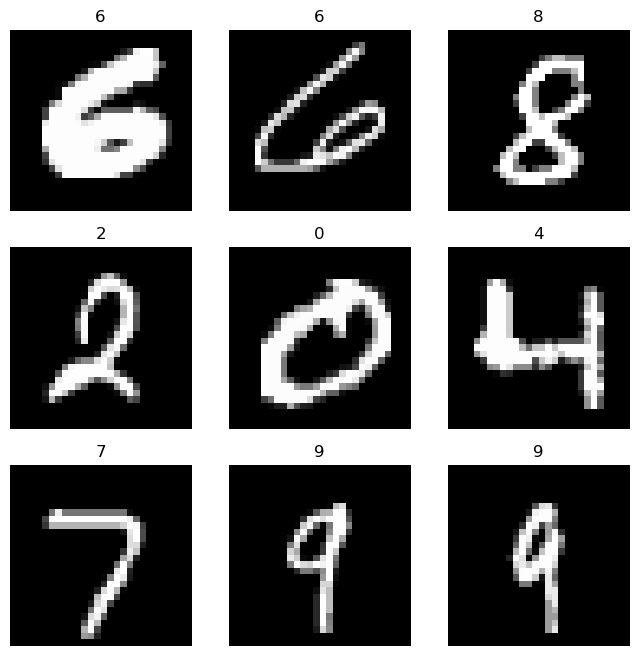

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

# 2. Data split

In [9]:
train_set.__len__(), valid_set.__len__()

(60000, 10000)

In [10]:
label_distr = pd.concat([
    pd.DataFrame(pd.Series(dataset.targets).value_counts(normalize=True)) 
        for dataset in [train_set, valid_set]
], axis=1).sort_index()
label_distr.columns = ['train_set', 'valid_set']
label_distr

,train_set,valid_set
0,0.098717,0.0980
1,0.112367,0.1135
2,0.099300,0.1032
3,0.102183,0.1010
4,0.097367,0.0982
5,0.090350,0.0892
6,0.098633,0.0958
7,0.104417,0.1028
8,0.097517,0.0974
9,0.099150,0.1009


In [11]:
train_set.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [12]:
class CustomSubset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        targets (sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, idxs):
        self.dataset = torch.utils.data.Subset(dataset, idxs)
        self.targets = dataset.targets[idxs]
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

def custom_random_split(dataset, frac):
    all_idxs = np.arange(0, len(dataset), 1)
    subset1_idxs = np.random.choice(all_idxs, int(frac*len(all_idxs)), replace=False)
    subset2_idxs = np.setdiff1d(all_idxs, subset1_idxs)

    return CustomSubset(dataset, subset1_idxs), CustomSubset(dataset, subset2_idxs)

In [13]:
train_mark_set, train_unmark_set = custom_random_split(train_set, 0.2)
train_mark_set.__len__(), train_unmark_set.__len__()

(12000, 48000)

In [14]:
label_distr = pd.concat([
    pd.DataFrame(pd.Series(dataset.targets).value_counts(normalize=True)) 
        for dataset in [train_mark_set, train_unmark_set]
], axis=1).sort_index()
label_distr.columns = ['train_mark_set', 'train_unmark_set']
label_distr

,train_mark_set,train_unmark_set
0,0.097917,0.098917
1,0.110167,0.112917
2,0.097833,0.099667
3,0.101583,0.102333
4,0.098000,0.097208
5,0.092000,0.089938
6,0.098083,0.098771
7,0.108250,0.103458
8,0.096667,0.097729
9,0.099500,0.099062


# 3. Base classifier

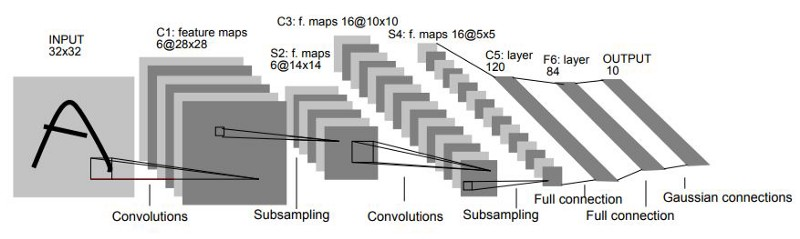

In [144]:
from torch import nn

class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # padding for 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))
    
model = LeNet5V1()
model.to(device)

LeNet5V1(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

# 4. Supervised Training

In [16]:
def train_epoch(epoch, model, train_loader, loss_func, optimizer):
    running_loss  = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        X_train, y_train = data
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_train_pred = model(X_train)
        
        loss = loss_func(y_train_pred, y_train)
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f'[{dt.datetime.now()}] Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 100 != 99:
        print(f'[{dt.datetime.now()}] Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / (i+1)}')
        running_loss = 0.0


def model_eval(model, data_loader, loss_func, accuracy=None):
    model.eval()
    
    loss_val = 0.0
    if accuracy is not None:
        acc_val = 0.0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_func(y_pred, y)
            loss_val += loss.item()

            if accuracy is not None:
                acc_val += accuracy(y_pred, y)

    if accuracy is None:
        return loss_val / len(data_loader)
    else:
        return loss_val / len(data_loader), acc_val / len(data_loader)

 
def train_and_eval_model(model, train_loader, valid_loader, num_epochs, loss_func, optimizer, accuracy):
    train_loss_per_epoch = list()
    train_accuracy_per_epoch = list()
    valid_loss_per_epoch = list()
    valid_accuracy_per_epoch = list()
    
    print(f'[{dt.datetime.now()}] Start training')
    for epoch in range(num_epochs):
        train_epoch(epoch, model, train_loader, loss_func, optimizer)
        
        train_loss, train_acc = model_eval(model, train_loader, loss_func, accuracy)
        train_loss_per_epoch.append(train_loss)
        train_accuracy_per_epoch.append(train_acc)
        print(f'[{dt.datetime.now()}] Epoch {epoch + 1}, Train Loss: {train_loss_per_epoch[-1]}, Train Accuracy: {train_accuracy_per_epoch[-1]}')
        
        valid_loss, valid_acc = model_eval(model, valid_loader, loss_func, accuracy)
        valid_loss_per_epoch.append(valid_loss)
        valid_accuracy_per_epoch.append(valid_acc)
        print(f'[{dt.datetime.now()}] Epoch {epoch + 1}, Valid Loss: {valid_loss_per_epoch[-1]}, Valid Accuracy: {valid_accuracy_per_epoch[-1]}')
    
    results = {
        'accuracy': {
            'train': [float(val) for val in train_accuracy_per_epoch],
            'valid': [float(val) for val in valid_accuracy_per_epoch]
        },
        'loss': {
            'train': train_loss_per_epoch,
            'valid': valid_loss_per_epoch
        }
    }
    return results

In [17]:
eval_per_epoch_dict = dict()

In [37]:
sl_model = deepcopy(model)

batch_size = 50
learning_rate = 0.01
num_epochs = 10

loss_func  = nn.CrossEntropyLoss()
optimizer = optim.SGD(sl_model.parameters(), lr=learning_rate)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)

In [38]:
eval_per_epoch_dict['sl_model'] = train_and_eval_model(
    sl_model, train_loader, valid_loader, num_epochs, loss_func, optimizer, accuracy
)

[2024-05-18 22:52:01.921034] Start training
[2024-05-18 22:52:02.897657] Epoch 1, Batch 100, Loss: 2.2988831210136413
[2024-05-18 22:52:03.841320] Epoch 1, Batch 200, Loss: 2.2868422722816466
[2024-05-18 22:52:04.789809] Epoch 1, Batch 300, Loss: 2.2713613438606264
[2024-05-18 22:52:05.739947] Epoch 1, Batch 400, Loss: 2.2421908283233645
[2024-05-18 22:52:06.684548] Epoch 1, Batch 500, Loss: 2.1808337593078613
[2024-05-18 22:52:07.632911] Epoch 1, Batch 600, Loss: 2.037972060441971
[2024-05-18 22:52:08.578580] Epoch 1, Batch 700, Loss: 1.7490852510929107
[2024-05-18 22:52:09.523620] Epoch 1, Batch 800, Loss: 1.4675259017944335
[2024-05-18 22:52:10.479129] Epoch 1, Batch 900, Loss: 1.224942135810852
[2024-05-18 22:52:11.461834] Epoch 1, Batch 1000, Loss: 1.0355399811267854
[2024-05-18 22:52:12.401936] Epoch 1, Batch 1100, Loss: 0.9088674640655517
[2024-05-18 22:52:13.358972] Epoch 1, Batch 1200, Loss: 0.8181432902812957
[2024-05-18 22:52:24.726746] Epoch 1, Train Loss: 0.771630818918347

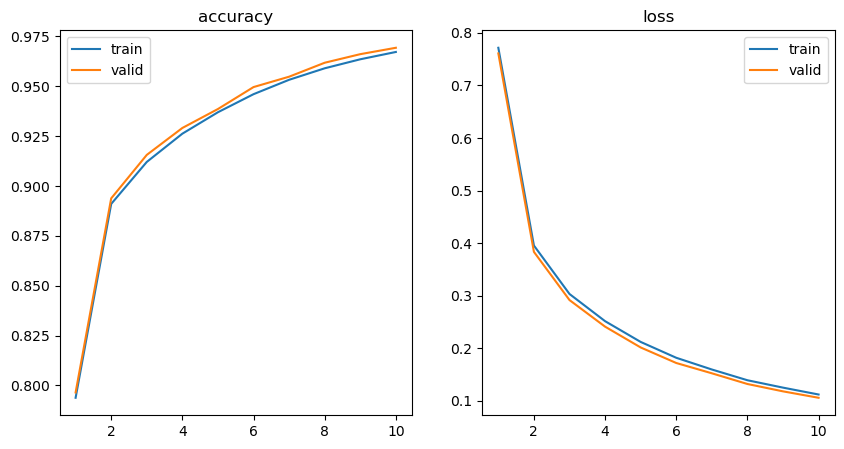

In [39]:
def plot_model_eval(model_name):
    metrics = list(eval_per_epoch_dict[model_name].keys())

    n = len(metrics)
    epoch_list = [i for i in range(1, num_epochs+1)]
    fig, ax = plt.subplots(1, n)
    fig.set_size_inches(10, 5)

    for i in range(n):
        ax[i].set_title(metrics[i])
        metric_vals = eval_per_epoch_dict[model_name][metrics[i]]
        for set_name in metric_vals.keys():
            ax[i].plot(epoch_list, metric_vals[set_name], label=set_name)
        ax[i].legend()

plot_model_eval('sl_model')

In [52]:
m_model = deepcopy(model)

batch_size = 50
learning_rate = 0.01
num_epochs = 10

loss_func  = nn.CrossEntropyLoss()
optimizer = optim.SGD(m_model.parameters(), lr=learning_rate)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

train_m_loader = torch.utils.data.DataLoader(train_mark_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)

In [53]:
eval_per_epoch_dict['m_model'] = train_and_eval_model(
    m_model, train_m_loader, valid_loader, num_epochs, loss_func, optimizer, accuracy
)

[2024-05-18 23:08:37.334634] Start training
[2024-05-18 23:08:38.361125] Epoch 1, Batch 100, Loss: 2.3003203225135804
[2024-05-18 23:08:39.348596] Epoch 1, Batch 200, Loss: 2.286690709590912
[2024-05-18 23:08:39.746241] Epoch 1, Batch 240, Loss: 0.3796541213989258
[2024-05-18 23:08:42.081964] Epoch 1, Train Loss: 2.2735964844624204, Train Accuracy: 0.3434999883174896
[2024-05-18 23:08:44.252189] Epoch 1, Valid Loss: 2.272759357690811, Valid Accuracy: 0.35009998083114624
[2024-05-18 23:08:45.256293] Epoch 2, Batch 100, Loss: 2.2622551321983337
[2024-05-18 23:08:46.259178] Epoch 2, Batch 200, Loss: 2.223430655002594
[2024-05-18 23:08:46.655553] Epoch 2, Batch 240, Loss: 0.3626258542140325
[2024-05-18 23:08:49.030202] Epoch 2, Train Loss: 2.153695770104726, Train Accuracy: 0.5345833897590637
[2024-05-18 23:08:50.913139] Epoch 2, Valid Loss: 2.1520342326164243, Valid Accuracy: 0.5365998148918152
[2024-05-18 23:08:51.907842] Epoch 3, Batch 100, Loss: 2.0737202548980713
[2024-05-18 23:08:52.

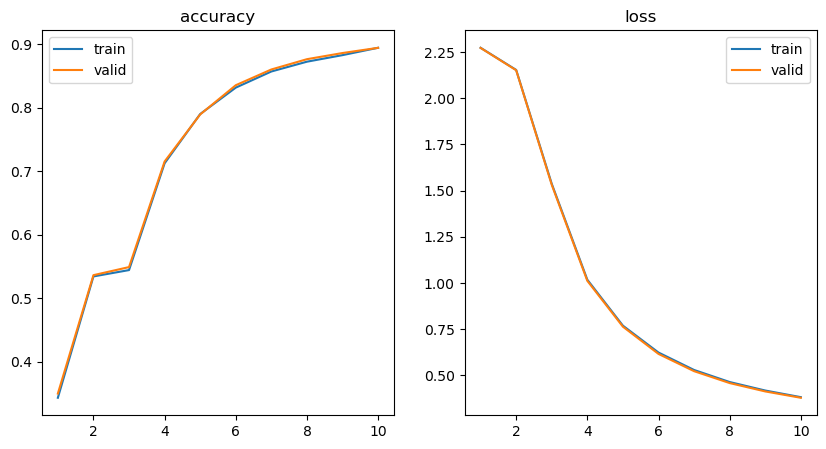

In [54]:
plot_model_eval('m_model')

# 5. Semi-Spervised RESSEL Training

In [76]:
def checkpoint_model(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume_model(model, filename):
    model.load_state_dict(torch.load(filename))

class RESSEL():
    def __init__(self, base_classifier, k, num_classes=10):
        self.base_classifier = base_classifier
        self.num_classes = num_classes
        self.k = k # number of classifiers in ensamble

    def _train_classifier(self, classifier_i, L_i_set, OOB_i_set, batch_size = 50, learning_rate = 0.01, num_epochs = 10):
        loss_func  = nn.CrossEntropyLoss()
        optimizer = optim.SGD(classifier_i.parameters(), lr=learning_rate)
        accuracy = Accuracy(task='multiclass', num_classes=self.num_classes).to(device)

        L_i_loader = torch.utils.data.DataLoader(L_i_set, batch_size=batch_size, shuffle=True)
        OOB_i_loader = torch.utils.data.DataLoader(OOB_i_set, batch_size=batch_size)

        OOB_i_error = train_and_eval_model(
            classifier_i, L_i_loader, OOB_i_loader, num_epochs, loss_func, optimizer, accuracy
        )['loss']['valid'][-1]

        return OOB_i_error

    def _robust_self_training(self, i, L_i_set, U_i_set, OOB_i_set, D_class_i, m=None, n=None):
        if m is None:
            m = int(int(self.uf*len(U_i_set))**.5) 
        if n is None:
            n = m
        
        OOB_i_best_error = self._train_classifier(self.classifiers[i], L_i_set, OOB_i_set)
        best_model_path = f'models/best_model_{i}.pth'
        checkpoint_model(self.classifiers[i], best_model_path)

        for j in range(m):
            print(f'[{dt.datetime.now()}] ########## Classifier {i+1}/{self.k}, RobustSelfTraining {j+1}/{m} ##########')
            self.classifiers[i].eval()
            U_i_loader = torch.utils.data.DataLoader(U_i_set, batch_size=batch_size)

            U_i_probs_list = list()
            with torch.no_grad():
                for X, _ in U_i_loader:
                    X = X.to(device)
                    U_i_probs_list.append(self.classifiers[i](X))
            U_i_probs = torch.cat(U_i_probs_list)
            
            n_class_i = (n * D_class_i).round()
            U_i_conf_idxs_list = list()
            for jj in range(len(n_class_i)):
                U_i_conf_idxs_list.append(
                    torch.topk(torch.transpose(U_i_probs, dim0=0, dim1=1)[jj], int(n_class_i[jj])).indices
                )
            U_i_conf_idxs = torch.cat(U_i_conf_idxs_list).to('cpu')
            U_i_confs = CustomSubset(U_i_set, U_i_conf_idxs)

            L_i_set = ConcatDataset([L_i_set, U_i_confs])

            self.classifiers[i] = deepcopy(self.base_classifier)
            OOB_i_error = self._train_classifier(self.classifiers[i], L_i_set, OOB_i_set)

            if OOB_i_error < OOB_i_best_error:
                print(f'[{dt.datetime.now()}] !!! New OOB_i_best_error, best model saved')
                OOB_i_best_error = OOB_i_error
                checkpoint_model(self.classifiers[i], best_model_path)
            
        resume_model(self.classifiers[i], best_model_path)
        self.classifiers[i].eval()

    def train(self, L_set, U_set, uf, m=None, n=None):
        print(f'[{dt.datetime.now()}] Start RESSEL training')
        self.classifiers = [deepcopy(self.base_classifier) for i in range(self.k)]
        
        for i in range(self.k):
            print(f'[{dt.datetime.now()}] >>>>>>>>>>>>>>>>>>>> Classifier {i+1}/{self.k} <<<<<<<<<<<<<<<<<<')
            L_idxs = np.arange(0, len(L_set), 1)
            L_i_idxs = np.random.choice(L_idxs, len(L_set), replace=True)
            L_i_set = CustomSubset(L_set, L_i_idxs)

            U_idxs = np.arange(0, len(U_set), 1)
            U_i_idxs = np.random.choice(U_idxs, int(UF*len(U_idxs)), replace=False)
            U_i_set = CustomSubset(U_set, U_i_idxs)

            OOB_i_idxs = np.setdiff1d(L_idxs, np.unique(L_i_idxs))
            OOB_i_set = CustomSubset(L_set, OOB_i_idxs)

            L_i_targets_count = L_i_set.targets.unique(return_counts=True)[1]
            D_class_i = L_i_targets_count / sum(L_i_targets_count)
        
            self._robust_self_training(i, L_i_set, U_i_set, OOB_i_set, D_class_i, m=m, n=n) 

    def predict(self, data_set, batch_size=50):
        data_loader = DataLoader(data_set, batch_size=batch_size)
        ressel_preds = list()

        for X, _ in data_loader:
            X = X.to(device)
            batch_all_preds = list() 
            for model in self.classifiers:
                model.eval()
                with torch.no_grad():
                    batch_model_preds = torch.argmax(model(X), dim=1)
                batch_all_preds.append(batch_model_preds)
            
            bacth_ressel_preds = torch.transpose(torch.stack(batch_all_preds), dim0=0, dim1=1).mode().values
            ressel_preds.append(bacth_ressel_preds)

        return torch.cat(ressel_preds).to('cpu')

In [77]:
ressel1 = RESSEL(base_classifier=model, k=15)
ressel1.train(train_mark_set, train_unmark_set, 0.4, m=10, n=1960) # used proposed formula in paper and proprotionaly changed m and n so m = 10 => less time retraining

[2024-05-19 00:16:08.127493] Start RESSEL training
[2024-05-19 00:16:08.153422] >>>>>>>>>>>>>>>>>>>> Classifier 1/15 <<<<<<<<<<<<<<<<<<
[2024-05-19 00:16:08.159406] Start training
[2024-05-19 00:16:09.210821] Epoch 1, Batch 100, Loss: 2.3007053208351134
[2024-05-19 00:16:10.197493] Epoch 1, Batch 200, Loss: 2.2878058218955992
[2024-05-19 00:16:10.595897] Epoch 1, Batch 240, Loss: 0.3796777456998825
[2024-05-19 00:16:12.983541] Epoch 1, Train Loss: 2.2742637703816095, Train Accuracy: 0.3539167046546936
[2024-05-19 00:16:13.884102] Epoch 1, Valid Loss: 2.2729091988669503, Valid Accuracy: 0.36509251594543457
[2024-05-19 00:16:14.926523] Epoch 2, Batch 100, Loss: 2.264108576774597
[2024-05-19 00:16:15.920138] Epoch 2, Batch 200, Loss: 2.2258718705177305
[2024-05-19 00:16:16.318450] Epoch 2, Batch 240, Loss: 0.3638175855080287
[2024-05-19 00:16:18.708089] Epoch 2, Train Loss: 2.1624153087536495, Train Accuracy: 0.4827501177787781
[2024-05-19 00:16:19.578758] Epoch 2, Valid Loss: 2.159240221

In [78]:
ressel2 = RESSEL(base_classifier=model, k=10)
ressel2.train(train_mark_set, train_unmark_set, 0.4, m=10, n=1960) # used proposed formula in paper and proprotionaly changed m and n so m = 10 => less time retraining

[2024-05-19 04:46:12.935617] Start RESSEL training
[2024-05-19 04:46:12.953598] >>>>>>>>>>>>>>>>>>>> Classifier 1/10 <<<<<<<<<<<<<<<<<<
[2024-05-19 04:46:12.958555] Start training
[2024-05-19 04:46:13.920222] Epoch 1, Batch 100, Loss: 2.30040726184845
[2024-05-19 04:46:14.877661] Epoch 1, Batch 200, Loss: 2.2867080616950988
[2024-05-19 04:46:15.265617] Epoch 1, Batch 240, Loss: 0.3796350618203481
[2024-05-19 04:46:17.480668] Epoch 1, Train Loss: 2.273277019460996, Train Accuracy: 0.32183322310447693
[2024-05-19 04:46:18.286543] Epoch 1, Valid Loss: 2.273798913098453, Valid Accuracy: 0.3103048801422119
[2024-05-19 04:46:19.245610] Epoch 2, Batch 100, Loss: 2.261819672584534
[2024-05-19 04:46:20.198151] Epoch 2, Batch 200, Loss: 2.222789416313171
[2024-05-19 04:46:20.581098] Epoch 2, Batch 240, Loss: 0.3626078575849533
[2024-05-19 04:46:22.816713] Epoch 2, Train Loss: 2.153030389547348, Train Accuracy: 0.5372500419616699
[2024-05-19 04:46:23.623526] Epoch 2, Valid Loss: 2.154413049140673

In [79]:
ressel3 = RESSEL(base_classifier=model, k=5)
ressel3.train(train_mark_set, train_unmark_set, 0.4, m=10, n=1960) # used proposed formula in paper and proprotionaly changed m and n so m = 10 => less time retraining

[2024-05-19 07:44:53.328610] Start RESSEL training
[2024-05-19 07:44:53.337603] >>>>>>>>>>>>>>>>>>>> Classifier 1/5 <<<<<<<<<<<<<<<<<<
[2024-05-19 07:44:53.341574] Start training
[2024-05-19 07:44:54.330960] Epoch 1, Batch 100, Loss: 2.299857859611511
[2024-05-19 07:44:55.309244] Epoch 1, Batch 200, Loss: 2.287400085926056
[2024-05-19 07:44:55.696182] Epoch 1, Batch 240, Loss: 0.37973679403464
[2024-05-19 07:44:57.903307] Epoch 1, Train Loss: 2.2743752261002856, Train Accuracy: 0.3244163990020752
[2024-05-19 07:44:58.724082] Epoch 1, Valid Loss: 2.2742954291654436, Valid Accuracy: 0.31820225715637207
[2024-05-19 07:44:59.682915] Epoch 2, Batch 100, Loss: 2.2632293343544005
[2024-05-19 07:45:00.638935] Epoch 2, Batch 200, Loss: 2.2270575332641602
[2024-05-19 07:45:01.024039] Epoch 2, Batch 240, Loss: 0.36370794574419657
[2024-05-19 07:45:03.249117] Epoch 2, Train Loss: 2.1617634654045106, Train Accuracy: 0.57791668176651
[2024-05-19 07:45:04.063908] Epoch 2, Valid Loss: 2.15903788470150

# 6. Results

In [158]:
results_df = pd.DataFrame()
def add_results(model_name, valid_acc):
    global results_df
    new_res_dict = {
        'valid_acc': [valid_acc]
    }
    new_results = pd.DataFrame(new_res_dict)
    results_df = pd.concat([results_df, new_results])

results_df

""


In [159]:
for model_name in eval_per_epoch_dict.keys():
    add_results(model_name, eval_per_epoch_dict[model_name]['accuracy']['valid'][-1])

def ressel_eval(ressel_model, data_set):
    y_pred = ressel_model.predict(data_set)
    y_true = data_set.targets
    return float(sum(y_pred==y_true)/len(y_true))

ressel_models = [ressel1, ressel2, ressel3]
ressel_names = ['ressel_k15', 'ressel_k10', 'ressel_k5']
for i in range(len(ressel_models)):
    add_results(ressel_names[i], ressel_eval(ressel_models[i], valid_set))

results_df

,model_name,valid_acc
0,sl_model,0.9693
0,m_model,0.8946
0,ressel_k15,0.9130
0,ressel_k10,0.9121
0,ressel_k5,0.9134
